In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, lil_matrix, hstack, vstack, linalg
import numpy.matlib
import pandas as pd
import matplotlib.patches as patches
import matplotlib.colors as colors
import Q2Q1FEM
import Q2Q1OPT
import PolyFEM
import time

In [2]:
nelm=16
Node,Element,NodeBC=Q2Q1OPT.SquareMeshQ2(nelm)
Node_P,Element_P,NodeBC_P=Q2Q1OPT.SquareMeshQ1(nelm)
fem_NElem = Element.shape[0]
fem_NElem_P = Element_P.shape[0]
zIni = 0.75*np.ones(fem_NElem)

In [3]:
fem_mu0 = 1               # Dynamic viscosity
fem_Reg = 0               # Tag for regular meshes
R = -1
Volfrac = 0.75
P_ori = np.identity(fem_NElem)
P_ori_P = np.identity(fem_NElem_P)
P = csr_matrix(P_ori)
P_P = csr_matrix(P_ori_P)   
opt_zMin=0.0    # Lower bound for design variables
opt_zMax=1.0    # Upper bound for design variables
opt_zIni = zIni # Initial design variables
opt_zIni_P = zIni
opt_P = P       # Matrix that maps design to element vars.
opt_P_P = P_P
opt_VolFrac = Volfrac  # Specified volume fraction cosntraint
opt_Tol = 0.01   # Convergence tolerance on design vars.
opt_MaxIter = 150  # Max. number of optimization iterations
opt_OCMove = 0.2  # Allowable move step in OC update scheme
opt_OCEta = 0.5  # Exponent used in OC update scheme
q = [0.01,0.1,1]

Obj 0.062094504769057195 frac 0.7500251954953315
Obj 0.030586422661775865 frac 0.7499996840707578
Obj 0.014659745353529596 frac 0.7499788971374475
Obj 0.011863933294991538 frac 0.7499291694968266
Obj 0.011052383322249473 frac 0.7499864964345493


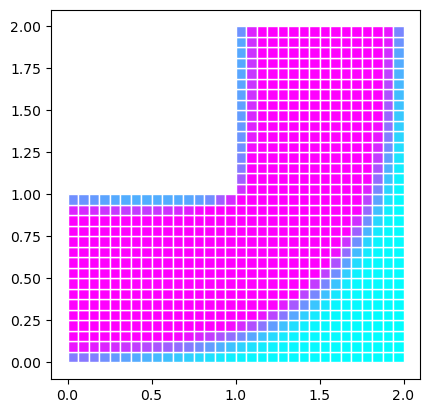

Obj 0.010969790470569299 frac 0.7500528751934286
Obj 0.010964529430410971 frac 0.7499516966562011
Obj 0.010980257915352653 frac 0.750048336078552
Obj 0.010982495653274013 frac 0.7499740958501023


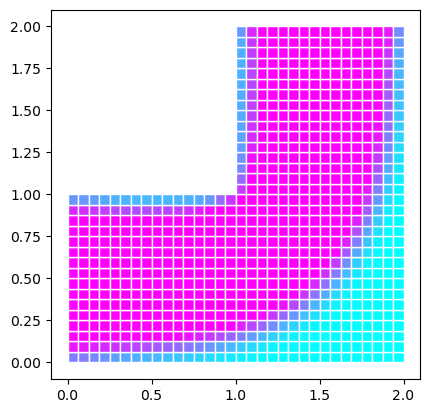

Obj 0.015326236909805512 frac 0.7499962898607122
Obj 0.012870545312915684 frac 0.7500064834356325
Obj 0.01251581036776368 frac 0.7500118240606478
Obj 0.012486422268532815 frac 0.7500076002901706
Obj 0.01247232523074448 frac 0.7500067510660807


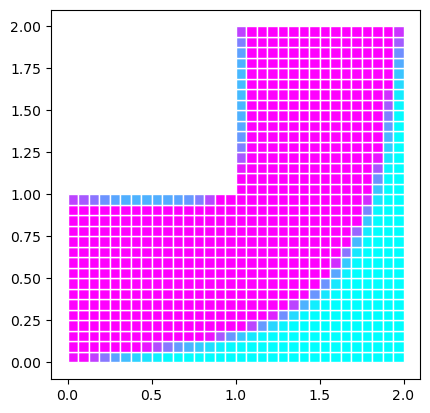

Obj 0.012462567594682516 frac 0.750007435260739
Obj 0.012455663874389782 frac 0.7500012642016074
Obj 0.012450710514852604 frac 0.7500038595967654
Obj 0.012446484018034477 frac 0.7500103124234826
Obj 0.012443623202939406 frac 0.7500085656043437


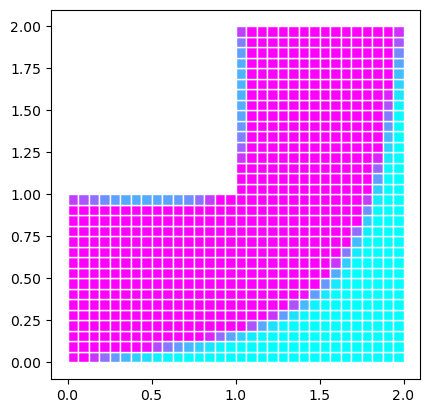

Obj 0.012442289788257246 frac 0.7499903379341809


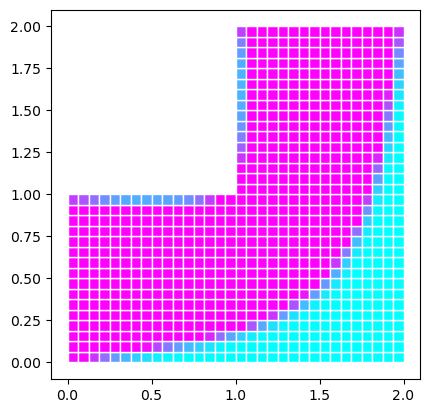

Obj 0.013785411046066327 frac 0.7499939059752236
Obj 0.013156026722081195 frac 0.7500051228560757
Obj 0.012933857641895644 frac 0.7500001246695737
Obj 0.012860010423169421 frac 0.7499967370845037
Obj 0.012827668197642278 frac 0.749993661431095


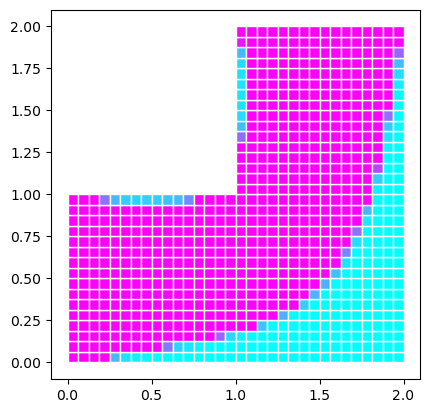

Obj 0.012806295115123833 frac 0.7500054021409714
Obj 0.012799165870509869 frac 0.7499957003039551
Obj 0.012793365207848895 frac 0.7499942450736478
Obj 0.012791711983715261 frac 0.7500005395617055
Obj 0.012790241261735474 frac 0.7499976203443381


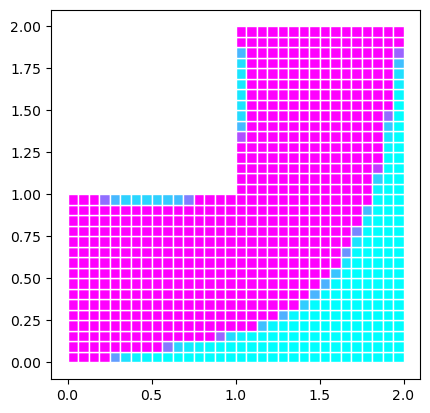

Obj 0.01278921895024902 frac 0.7500001843650921
Obj 0.012788116651880942 frac 0.7499949441225073
Obj 0.012787209038352187 frac 0.7499986719205284
Obj 0.012785941503085003 frac 0.7500001871661709
Obj 0.012784511953227926 frac 0.7500061677369153


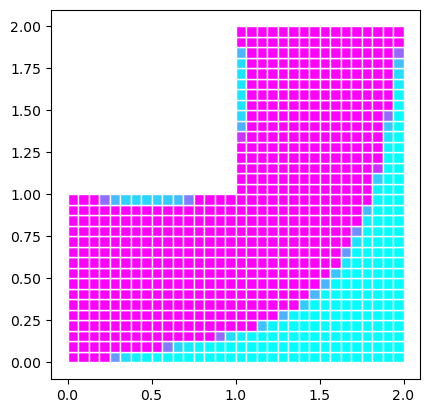

Obj 0.012782577508364932 frac 0.750000252549628
Obj 0.012780347347418036 frac 0.7500019200508034
Obj 0.012776714074439598 frac 0.7500042618716337
Obj 0.012770310880009657 frac 0.7499950266288321
Obj 0.012763259471962161 frac 0.7499948426587603


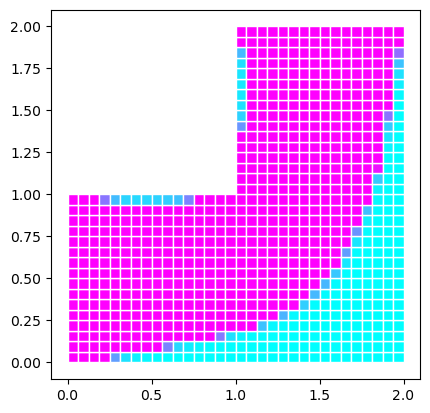

Obj 0.012760128578932536 frac 0.7500025026881846
Obj 0.012752961457983835 frac 0.7500034887439665
Obj 0.012753650542501565 frac 0.7499994044113314
Obj 0.012754215621940516 frac 0.7500031419453315


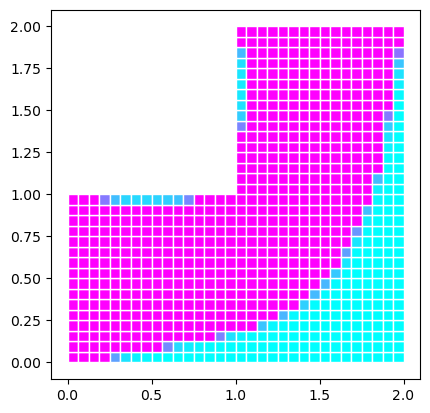

In [17]:
obj = []
frac = []
z=opt_zIni
iteration = 0
start = time.time()
for i in range(3):
    Tol=opt_Tol*(opt_zMax-opt_zMin)
    Change=2*Tol
    z_P = opt_zIni_P
    P=opt_P
    P_P = opt_P_P
    E,dEdy,V,dVdy = Q2Q1OPT.MatIntFnc(P*z,np.array([fem_mu0,q[i]]))
    E_P,dEdy_P,V_P,dVdy_P = Q2Q1OPT.MatIntFnc(P_P*z_P,np.array([fem_mu0,q[i]]))
    Iter = 0
    while (Iter<opt_MaxIter) and Change>Tol:
        Iter += 1
        iteration+=1
        g,dgdE,dgdV,fem_ElemArea = Q2Q1OPT.ConstraintFncQ2(fem_NElem,Node,Element,E,V,Volfrac)
        f,dfdE,dfdV = Q2Q1OPT.ObjectiveFnc(Node,Element,NodeBC,Node_P,Element_P,NodeBC_P,z,fem_ElemArea,E,V)
        p_poly,f_new_poly,u_poly,v_poly = PolyFEM.PolyFEM(Node_P,Element_P,NodeBC_P,z)
        dfdz = P.T*(np.multiply(dEdy,dfdE)+np.multiply(dVdy,dfdV))
        dgdz = P.T*(np.multiply(dEdy,dgdE)+np.multiply(dVdy,dgdV))
        z,Change = Q2Q1OPT.UpdateScheme(dfdz,g,dgdz,z,opt_zMin,opt_zMax,opt_OCMove,opt_OCEta)
        E,dEdy,V,dVdy = Q2Q1OPT.MatIntFnc(P*z,np.array([fem_mu0,q[i]]))
        print('Obj',f,'frac',z.sum()/(nelm*nelm*3))
        obj.append(f)
        frac.append(z.sum()/(nelm*nelm*3))
        if Iter%5==0:
            Q2Q1OPT.Plot_patch(nelm,Node_P,Element_P,z,1,0,cmap='cool')
    Q2Q1OPT.Plot_patch(nelm,Node_P,Element_P,z,1,0,cmap='cool')
end = time.time()

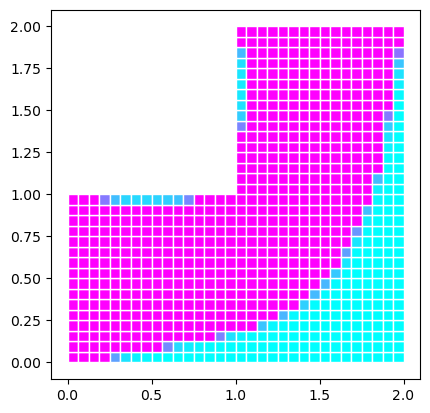

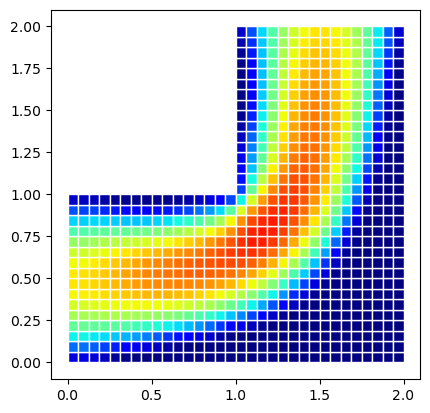

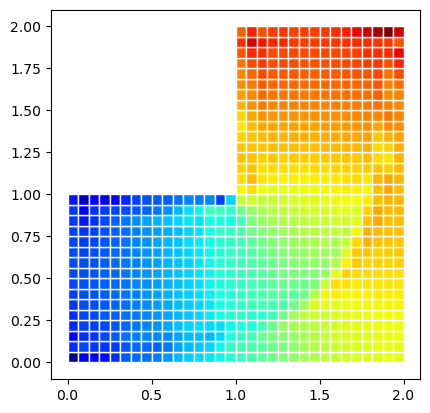

11.270351778253744
44
145.12883925437927
0.7500031419453315


In [6]:
p,f_new,u,v = Q2Q1FEM.Q2Q1FEM(Node,Element,NodeBC,Node_P,Element_P,NodeBC_P,z) #original
p_poly,f_new_poly,u_poly,v_poly = PolyFEM.PolyFEM(Node_P,Element_P,NodeBC_P,z)
Q2Q1FEM.Plot_patch(nelm,Node_P,Element_P,z,1,0,cmap='cool')
Q2Q1FEM.Plot_patch(nelm,Node_P,Element_P,(np.sqrt(u**2+v**2)),1.5,0,cmap='jet')
Q2Q1FEM.Plot_patch(nelm,Node_P,Element_P,p,max(p),min(p),cmap='jet')
print(f_new_poly)
print(iteration)
print(end-start)
print(z.sum()/(nelm*nelm*3))

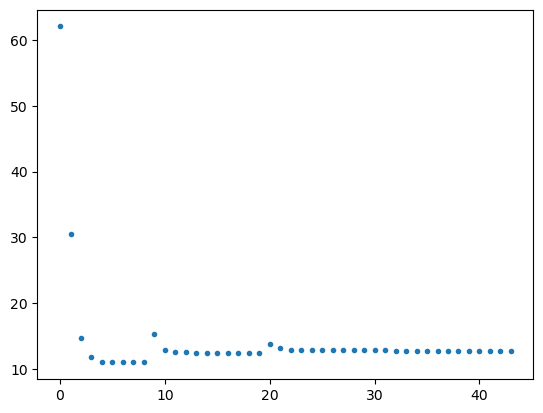

In [27]:
fig, ax1 = plt.subplots()
#ax2 = ax1.twinx()
ax1.plot(obj_new,label="Objective function",marker='.',linestyle='none')
# ax2.plot(frac,label='Volume fraction',color='r')
# ax2.plot([0,len(frac)],[0.75,0.75],color='b')
handler1, label1 = ax1.get_legend_handles_labels()
#handler2, label2 = ax2.get_legend_handles_labels()
#ax1.legend(handler1 + handler2, label1 + label2,frameon=False)

In [26]:
obj_new=[]
for i in range(len(obj)):
    obj_new.append(obj[i]*1000) 